<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%92%D0%B0%D1%80_%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_Light_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек

Сделайте более мощный CVAE, обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге. Коррелирует ли уровень ошибки с качеством изображений?

Подайте 5 раз в decoder CVAE один и тот же случайный вектор и любой label от 0 до 9 на выбор. Посмотрите, что сгенерирует CVAE.

In [ ]:
!pip install keras==2.0 -q
!pip install tensorflow==1.13.2 -q -q

     |████████████████████████████████| 191 kB 4.3 MB/s 
     |████████████████████████████████| 458.3 MB 10 kB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 458.3 MB 10 kB/s 
     |████████████████████████████████| 454.4 MB 22 kB/s 
     |████████████████████████████████| 4.0 MB 53.3 MB/s 
     |████████████████████████████████| 1.2 MB 64.9 MB/s 
     |████████████████████████████████| 462 kB 76.4 MB/s 
     |████████████████████████████████| 92.7 MB 53 kB/s 
     |████████████████████████████████| 3.2 MB 24.8 MB/s 
     |████████████████████████████████| 367 kB 93.6 MB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.13.2 which is incompatible.


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm # модуль с нормальными непрерывными распределениями
%matplotlib inline

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import  Input, Dense, Dropout, BatchNormalization, Flatten, Reshape, Lambda, concatenate, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import  Adam, RMSprop
from tensorflow.keras.callbacks import  LambdaCallback, ReduceLROnPlateau, TensorBoard

from IPython.display import clear_output # модуль очистки output ячейки


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Mnist

In [ ]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32')/255
xTest = xTest.astype('float32')/255
xTrain = np.reshape(xTrain, (len(xTrain), 28, 28, 1)) # или  =xTrain.reshape(-1, 28, 28, 1)
xTest = xTest.reshape(-1, 28, 28, 1)
print(xTrain.shape) # проверяю, правильно ли я перевёл разными способами
print(xTest.shape)

y_train_cat = to_categorical(yTrain, 10).astype(np.float32) #  на какой чёрт такое длинное название переменной?
y_test_cat = to_categorical(yTest, 10).astype('float32') # а можно и так перевести
print(y_train_cat.shape) # опять проверяю эксперимент
print(y_test_cat.shape)
num_classes = y_test_cat.shape[1]


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


гиперпараметры:

In [ ]:
batch_size = 500
latent_dim = 8 # латентный или скрытое пространство, размер
dropout_rate = 0.3 # избежание переобучения 
start_lr = 0.001 # шаг обучения

# Функции 

функция создания вариационного автокодировщика с условием:

In [ ]:
def create_cvae():
  models = {} # создание словаря моделей, которые объявятся потом
  def apply_bn_and_dropout(x):
    return Dropout(dropout_rate)(BatchNormalization()(x)) # тут понятно. Только на  return где запятая между дропом и нормализат.. пока не понятно

  # ЭНКОДЕР
  input_img = Input(shape=(28, 28, 1))
  flatten_img = Flatten()(input_img)
  input_lbl = Input(shape=(num_classes,), dtype='float32')#  лейблы в втором входе, с учётом 10 классов  в OHE

  x = concatenate([flatten_img, input_lbl]) # соединяем
  x = Dense(256, activation='relu')(x)
  x = apply_bn_and_dropout(x) # дропуем и нормализуем. ф-ция выше.
  
  # вводим новые переменные
  z_mean = Dense(latent_dim)(x)
  z_log_var = Dense(latent_dim)(x) # потом выскочит 
  def sampling(args): # хитрая функция
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1.0) #  мат. ожидание и отклонение можно было и не писать, оно по умолчанию
    return z_mean + K.exp(z_log_var/2) * epsilon
  
  l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])# тут надо вернутся к видеолекции

  models['encoder'] = Model([input_img, input_lbl], l) # до Лямда слоя
  models['z_meaner'] = Model([input_img, input_lbl], z_mean)
  models['z_lvarer'] = Model([input_img, input_lbl], z_log_var)

  # ДЕКОДЕР
  z = Input(shape=(latent_dim,)) #  первый вход
  input_lbl_d = Input(shape=(num_classes,), dtype='float32')
  x = concatenate([z, input_lbl_d])
  x = Dense(256)(x)
  x = LeakyReLU()(x) #  не понимаю, зачем отдельным слоем
  x = Dense(28*28, activation='sigmoid')(x)
  decoded = Reshape((28, 28, 1))(x)

  models['decoder'] = Model([z, input_lbl_d], decoded, name='Decoder') # модель декодера

  # Собираю, но чую где тоо ошибусь
  models['cvae'] = Model([input_img, input_lbl, input_lbl_d],
                         models['decoder']([models['encoder']([input_img, input_lbl]), input_lbl_d]), name='CVAE')
  
  models['style_t'] = Model([input_img, input_lbl, input_lbl_d],
                         models['decoder']([models['z_meaner']([input_img, input_lbl]), input_lbl_d]), name='style_transfer')
  
  def vae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, 28*28))
    decoded = K.reshape(decoded, shape=(batch_size, 28*28))
    xent_loss = 28*28*binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss)/3/28/28 # тут сказали можно поиграться

  return models, vae_loss

models, vae_loss = create_cvae() # получаем из функции, модели и функцию vae_loss  потерь
cvae = models['cvae']
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
digit_size = 28 

def plot_digits(*args, invert_colors=False): 
    args = [x.squeeze() for x in args] 
    figure = np.zeros((digit_size * len(args), digit_size * n)) 

    for i in range(n):
        for j in range(len(args)): 
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: 
        figure = 1-figure 

    plt.figure(figsize=(2*n, 2*len(args))) 
    plt.imshow(figure, cmap='Greys_r') 
    plt.grid(False) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
    plt.show() 


n = 15 


# Нейронка

In [ ]:
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = xTest[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
#utils.plot_model(cvae, dpi=60, show_shapes=True)

In [ ]:
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model (Model)                   (500, 8)             208656      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________

In [ ]:
cvae.fit([xTrain, y_train_cat, y_train_cat], xTrain, shuffle=True, epochs=100, batch_size=batch_size,
         validation_data=([xTest, y_test_cat, y_test_cat], xTest), verbose=1)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1053 - val_loss: 0.0695
Epoch 2/100
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0668 - val_loss: 0.0613
Epoch 3/100
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0612 - val_loss: 0.0581
Epoch 4/100
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0587 - val_loss: 0.0561
Epoch 5/100
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0571 - val_loss: 0.0548
Epoch 6/100
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0559 - val_loss: 0.0538
Epoch 7/100
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0550 - val_loss: 0.0530
Epoch 8/100
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0543 - val_loss: 0.0523
Epoch 9/100
60000/60000 [============

чего то callback не пошёл. не хочет и  всё в чём ошибка не врубаюсь

# Результат

In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу

    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

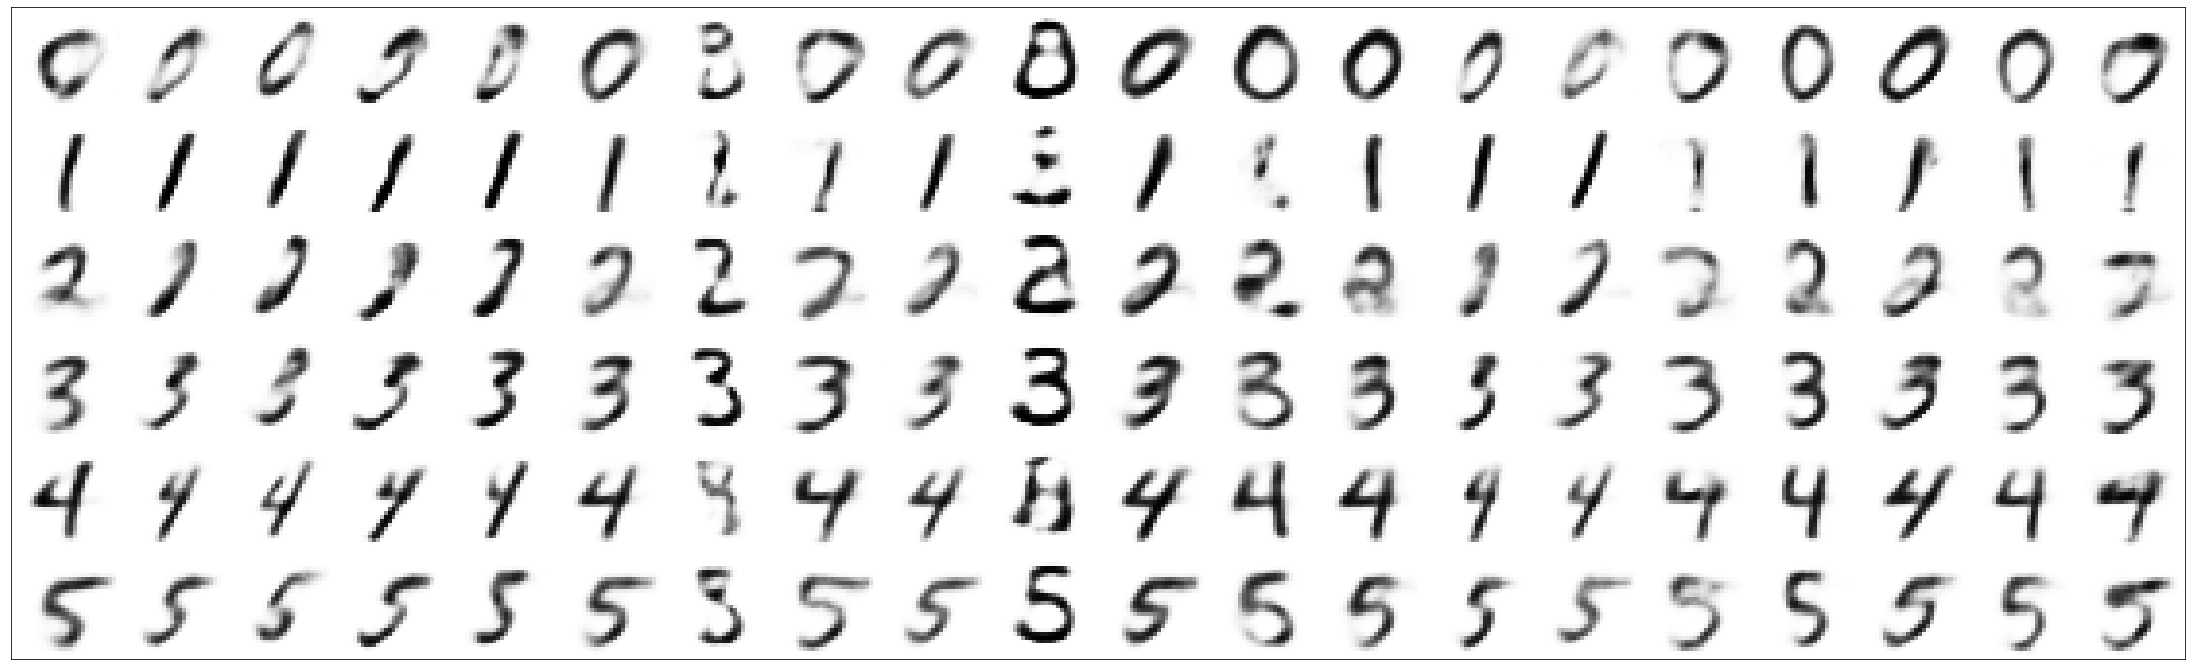

In [ ]:
n = 20 # выбираем количество картинок
lbl = 9 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = xTrain[yTrain == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла 

for i in range(6): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля


plot_digits(*generated, invert_colors=True) # отрисовываем картинки

# 5 векторов

Спасибо кураторам, что не дали голове разлететься на мелкие кусочки

первый:

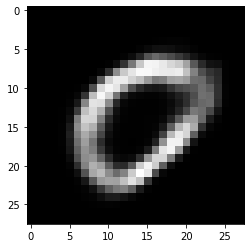

In [ ]:
gru = np.random.normal(0, 1, 8)[None, ...]
dig = to_categorical(0, 10)[None, ...]
pred = models['decoder'].predict([gru, dig])
input = pred.reshape((28, 28))
plt.imshow(input, cmap='gray')
plt.show()

второй:

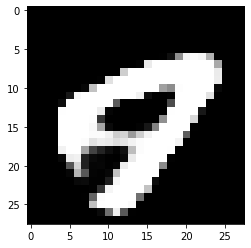

In [ ]:
gru = np.random.normal(3, 3, 8)[None, ...]
dig = to_categorical(0, 10)[None, ...]
pred = models['decoder'].predict([gru, dig])
input = pred.reshape((28, 28))
plt.imshow(input, cmap='gray')
plt.show()

третий:

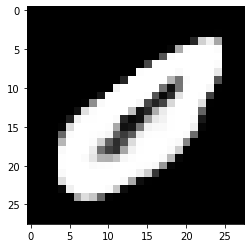

In [ ]:
gru = np.random.normal(5, 2, 8)[None, ...]
dig = to_categorical(0, 10)[None, ...]
pred = models['decoder'].predict([gru, dig])
input = pred.reshape((28, 28))
plt.imshow(input, cmap='gray')
plt.show()

четвёртый:

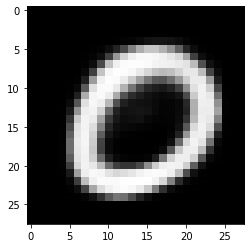

In [ ]:
gru = np.random.normal(0, 1, 8)[None, ...]
dig = to_categorical(0, 10)[None, ...]
pred = models['decoder'].predict([gru, dig])
input = pred.reshape((28, 28))
plt.imshow(input, cmap='gray')
plt.show()

пятый:

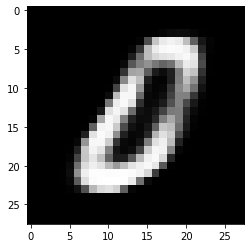

In [ ]:
gru = np.random.normal(0, 1, 8)[None, ...]
dig = to_categorical(0, 10)[None, ...]
pred = models['decoder'].predict([gru, dig])
input = pred.reshape((28, 28))
plt.imshow(input, cmap='gray')
plt.show()